# Final Project - Income Discrimination(Hao Yang, Stefan Lin)

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from scipy import stats

## 1. Load Data & Data Modification

In [111]:
df = pd.read_csv('cleaned_data.csv')

Protected Features: Sex, age, marst, race, citizen, diffrem, diffphys, diffeye, diffhear

### 1.1 Sex encoding

In [112]:
# 0 is male & 1 is female
df['SEX'] = df['SEX'].apply(lambda x: 1 if x==2 else 0)
df.head()

,SEX,AGE,MARST,FERTYR,RACE,CITIZEN,SPEAKENG,HCOVANY,EMPSTAT,UHRSWORK,DIFFREM,DIFFPHYS,DIFFEYE,DIFFHEAR,VETSTAT,EDU_ATT,DIPLOMA,INC_INDEX
0,1,35,1,0.000000,4,0,2,0,1,30,0,0,0,0,0,5,1,0
1,1,45,4,0.000000,2,1,3,1,0,0,0,0,0,0,0,4,1,0
2,1,23,6,0.000000,2,1,3,1,0,0,0,0,0,0,0,4,0,0
3,1,48,5,0.000000,1,1,3,1,1,40,0,0,0,0,0,5,1,0
4,1,52,6,0.042147,8,1,3,1,1,40,0,0,0,0,0,5,3,1


### 1.2 Race encoding

In [156]:
df['RACE'] = df['RACE'].apply(lambda x: 1 if x==1 else 0)
df.head()

,SEX,AGE,MARST,FERTYR,RACE,CITIZEN,SPEAKENG,HCOVANY,EMPSTAT,UHRSWORK,DIFFREM,DIFFPHYS,DIFFEYE,DIFFHEAR,VETSTAT,EDU_ATT,DIPLOMA,INC_INDEX
0,1,35,1,0.000000,0,0,2,0,1,30,0,0,0,0,0,5,1,0
1,1,45,4,0.000000,0,1,3,1,0,0,0,0,0,0,0,4,1,0
2,1,23,6,0.000000,0,1,3,1,0,0,0,0,0,0,0,4,0,0
3,1,48,5,0.000000,1,1,3,1,1,40,0,0,0,0,0,5,1,0
4,1,52,6,0.042147,0,1,3,1,1,40,0,0,0,0,0,5,3,1


In [113]:
print(df.shape)

(514548, 18) (514548, 18)


In [169]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

## 2. Fairness in data

### 2.1 T-test on different group

#### 2.1.1 Sex Analysis

In [117]:
p_value_df = stats.ttest_ind(df[df['SEX'] == 0]['INC_INDEX'],
                             df[df['SEX'] == 1]['INC_INDEX'])
print(p_value_df)

Ttest_indResult(statistic=47.35319932717478, pvalue=0.0)


From the p-value I got above, since the p-value is smaller than 0.05, it means that we could reject the null hypothesis, which means the income of male is significantly different than the income of female.

In [118]:
mean_1 = df[df['SEX'] == 0]['INC_INDEX'].mean()
mean_2 = df[df['SEX'] == 1]['INC_INDEX'].mean()
print(mean_1,mean_2)

0.461815262109175 0.39647546278580803


C:\Users\83968\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SEX', ylabel='INC_INDEX'>

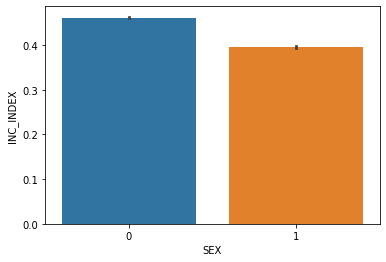

In [119]:
sns.barplot('SEX','INC_INDEX',data=df)

#### 2.1.2 Race Analysis

In [157]:
p_value_df_race = stats.ttest_ind(df[df['RACE'] == 0]['INC_INDEX'],
                                  df[df['RACE'] == 1]['INC_INDEX'])
print(p_value_df_race)

Ttest_indResult(statistic=-58.02014998001195, pvalue=0.0)


C:\Users\83968\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RACE', ylabel='INC_INDEX'>

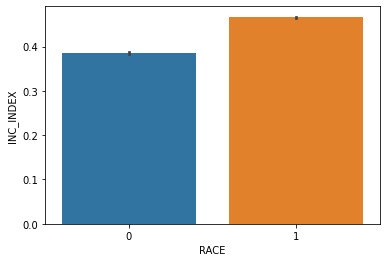

In [158]:
sns.barplot('RACE','INC_INDEX',data=df)

#### 2.1.3 Citizen Analysis

In [167]:
p_value_df_citizen = stats.ttest_ind(df[df['CITIZEN'] == 0]['INC_INDEX'],
                                     df[df['CITIZEN'] == 1]['INC_INDEX'])
print(p_value_df_citizen)

Ttest_indResult(statistic=-143.18075870901524, pvalue=0.0)


C:\Users\83968\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CITIZEN', ylabel='INC_INDEX'>

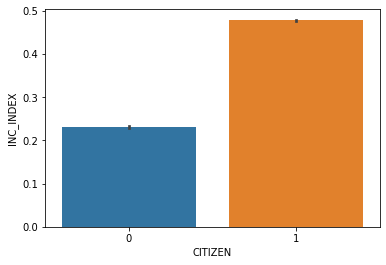

In [168]:
sns.barplot('CITIZEN','INC_INDEX',data=df)

#### 2.1.4 DIFFREM Analysis

In [175]:
p_value_df_diffrem = stats.ttest_ind(df[df['DIFFREM'] == 0]['INC_INDEX'],
                                     df[df['DIFFREM'] == 1]['INC_INDEX'])
print(p_value_df_diffrem)

Ttest_indResult(statistic=37.18631820777337, pvalue=2.8744561008124186e-302)


C:\Users\83968\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DIFFREM', ylabel='INC_INDEX'>

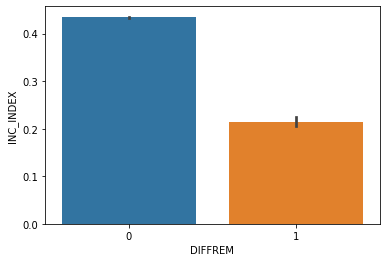

In [176]:
sns.barplot('DIFFREM','INC_INDEX',data=df)

#### 2.1.5 DIFFPHYS Analysis

In [183]:
p_value_df_diffphys = stats.ttest_ind(df[df['DIFFPHYS'] == 0]['INC_INDEX'],
                                      df[df['DIFFPHYS'] == 1]['INC_INDEX'])
print(p_value_df_diffphys)

Ttest_indResult(statistic=19.678719656411264, pvalue=3.531140183129426e-86)


C:\Users\83968\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DIFFPHYS', ylabel='INC_INDEX'>

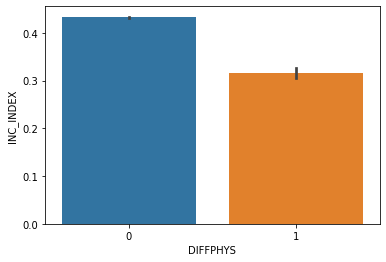

In [184]:
sns.barplot('DIFFPHYS','INC_INDEX',data=df)

#### 2.1.6 DIFFEYE Analysis

In [202]:
p_value_df_diffeye = stats.ttest_ind(df[df['DIFFEYE'] == 0]['INC_INDEX'],
                                     df[df['DIFFEYE'] == 1]['INC_INDEX'])
print(p_value_df_diffeye)

Ttest_indResult(statistic=17.28270203024611, pvalue=6.63334311407655e-67)


C:\Users\83968\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DIFFEYE', ylabel='INC_INDEX'>

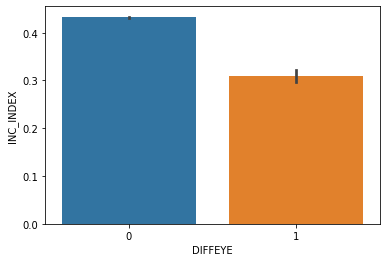

In [204]:
sns.barplot('DIFFEYE','INC_INDEX',data=df)

#### 2.1.7 DIFFHEAR Analysis

In [214]:
p_value_df_diffhear = stats.ttest_ind(df[df['DIFFHEAR'] == 0]['INC_INDEX'],
                                     df[df['DIFFHEAR'] == 1]['INC_INDEX'])
print(p_value_df_diffhear)

Ttest_indResult(statistic=3.246287895706144, pvalue=0.0011692801120987758)


C:\Users\83968\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DIFFHEAR', ylabel='INC_INDEX'>

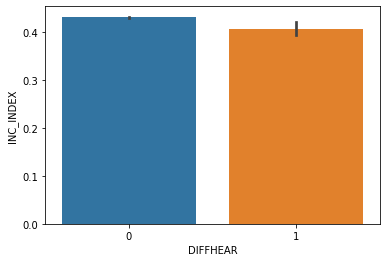

In [215]:
sns.barplot('DIFFHEAR','INC_INDEX',data=df)

### 2.2 Fairness evaluation metrics

In [148]:
def stat_parity(preds, sens):
    # Calculate statistical parity: P(preds=1|sens=1) - P(preds=1|sens=0)
    # Calculating P(preds=1|sens=1) by using conditional probability
    # P(preds=1|sens=1) = P(preds=1&sens=1)/P(sens=1)
    # Calculating P(preds=1&sens=1)
    count_p1ns1_sp = 0
    for i in range(len(preds)):
      if preds[i] == 1 and sens[i] == 1:
        count_p1ns1_sp += 1
    p_p1ns1_sp = count_p1ns1_sp/len(preds)
    # Calculating P(sens=1)
    count_s1_sp = 0
    for i in sens:
      if i == 1:
        count_s1_sp += 1
    p_s1_sp = count_s1_sp/len(sens) 
    # Calculating P(preds=1|sens=1)
    p_p1gs1_sp = (p_p1ns1_sp/p_s1_sp) if p_s1_sp != 0 else 0

    # Calculating P(preds=1|sens=0) using conditional probability
    # P(preds=1|sens=0) = P(preds=1&sens=0)/P(sens=0)
    # Calculating P(preds=1&sens=0)
    count_p1ns0_sp = 0
    for i in range(len(preds)):
      if preds[i] == 1 and sens[i] == 0:
        count_p1ns0_sp += 1
    p_p1ns0_sp = count_p1ns0_sp /len(preds)
    # Calculating P(sens=0)
    count_s0_sp = 0
    for i in sens:
      if i == 0:
        count_s0_sp += 1
    p_s0_sp = count_s0_sp/len(sens)
    # Calculating P(preds=1|sens=0)
    p_p1gs0_sp = (p_p1ns0_sp/p_s0_sp) if p_s0_sp != 0 else 0
    # Return P(preds=1|sens=1) - P(preds=1|sens=0)
    return p_p1gs0_sp - p_p1gs1_sp

def eq_oppo(preds, sens, labels):
    # Calculate equal opportunity: P(preds=1|sens=1,labels=1) - P(preds=1|sens=0,labels=1)
    # Calculating P(preds=1|sens=1,labels=1) by using conditional probability
    # P(preds=1|sens=1,labels=1) = P(preds=1&sens=1&labels=1) / P(sens=1&labels=1)
    # Calculating P(preds=1&sens=1&labels=1)
    count_p1ns1nl1_eq = 0
    for i in range(len(preds)):
      if preds[i] == 1 and sens[i] == 1 and labels[i] == 1:
        count_p1ns1nl1_eq += 1
    p_p1ns1nl1_eq = count_p1ns1nl1_eq/len(preds)
    # Calculating P(sens=1&labels=1)
    count_s1nl1_eq = 0
    for i in range(len(sens)):
      if sens[i] == 1 and labels[i] == 1:
        count_s1nl1_eq += 1
    p_s1nl1_eq = count_s1nl1_eq/len(sens)
    # Calculating P(preds=1|sens=1,labels=1)
    p_p1gs1l1_eq = (p_p1ns1nl1_eq/p_s1nl1_eq) if p_s1nl1_eq != 0 else 0

    # Calculating P(preds=1|sens=0,labels=1) by using conditional probability
    # P(preds=1|sens=0,labels=1) = P(preds=1&sens=0&labels=1) / P(sens=0&labels=1)
    # Calculating P(preds=1&sens=0&lables=1)
    count_p1ns0nl1_eq = 0
    for i in range(len(preds)):
      if preds[i] == 1 and sens[i] == 0 and labels[i] == 1:
        count_p1ns0nl1_eq += 1
    p_p1ns0nl1_eq = count_p1ns0nl1_eq/len(preds)
    # Calculating P(sens=0&labels=1)
    count_s0nl1_eq = 0
    for i in range(len(sens)):
      if sens[i] == 0 and labels[i] == 1:
        count_s0nl1_eq += 1
    p_s0nl1_eq = count_s0nl1_eq/len(sens)
    # Calculating P(preds=1|sens=0,labels=1)
    p_p1gs0l1_eq = p_p1ns0nl1_eq/p_s0nl1_eq if p_s0nl1_eq != 0 else 0
    # Return P(preds=1|sens=1,labels=1) - P(preds=1|sens=0,labels=1)
    return p_p1gs0l1_eq - p_p1gs1l1_eq 

## 3. Model Selection

### 3.1 Logistic Regression

#### 3.1.1 Feature Selection

<AxesSubplot:>

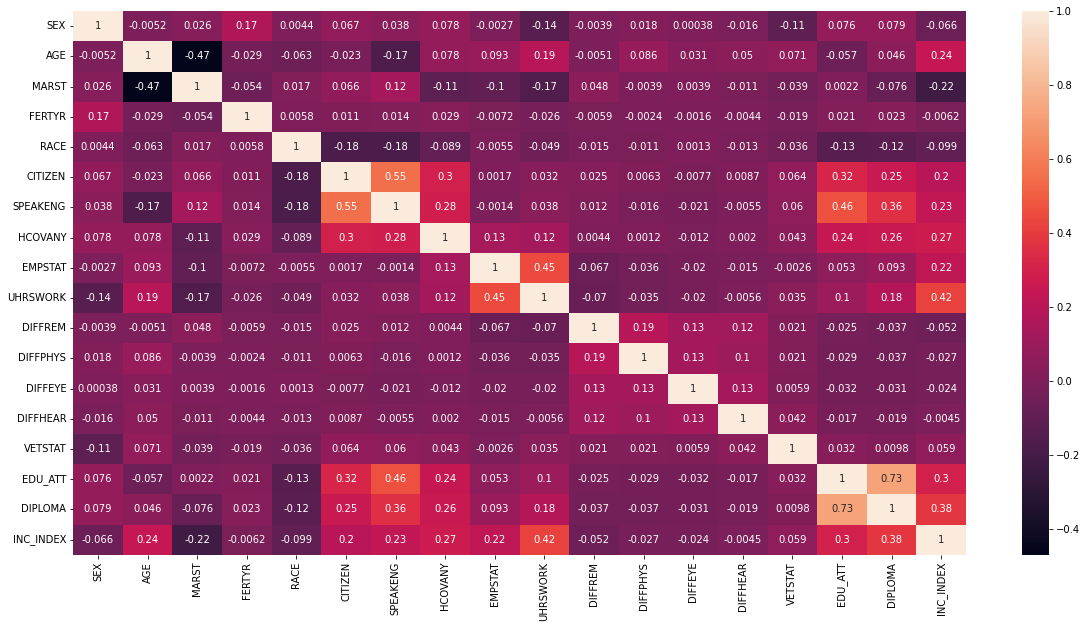

In [86]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [57]:
model = LogisticRegression(max_iter=1000)
rfecv = RFECV(estimator=model, step=1, cv=10, scoring='accuracy')
rfecv.fit(X_train,y_train)
print('Optimal number of features: {}'.format(rfecv.n_features_))
print('Selected features: {}'.format(list(X.columns[rfecv.support_])))

Optimal number of features: 17
Selected features: ['SEX', 'AGE', 'MARST', 'FERTYR', 'RACE', 'CITIZEN', 'SPEAKENG', 'HCOVANY', 'EMPSTAT', 'UHRSWORK', 'DIFFREM', 'DIFFPHYS', 'DIFFEYE', 'DIFFHEAR', 'VETSTAT', 'EDU_ATT', 'DIPLOMA']


In [58]:
rfe_average = []
for i in rfecv.grid_scores_:
    rfe_average.append(i.mean())

C:\Users\83968\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


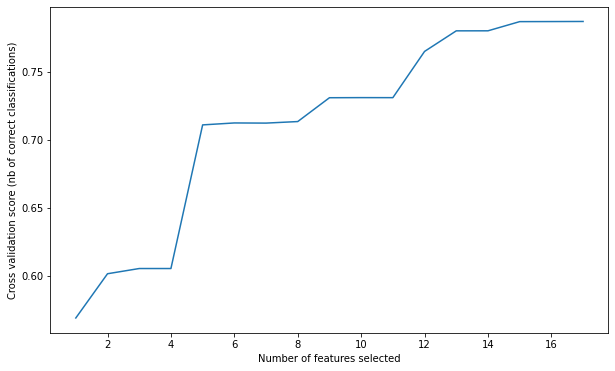

In [59]:
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfe_average)
plt.show()

#### 3.1.2 Model evaluation based on train/test split

In [88]:
selected_cols = ['SEX', 'AGE', 'MARST', 'FERTYR', 'RACE', 'CITIZEN', 'SPEAKENG', 'HCOVANY', 'EMPSTAT', 'UHRSWORK', 'DIFFREM', 'DIFFPHYS', 'DIFFEYE', 'DIFFHEAR', 'VETSTAT', 'EDU_ATT', 'DIPLOMA']
X_log = df[selected_cols]
y_log = df['INC_INDEX']
print(X_log.shape,y_log.shape)

(514548, 17) (514548,)


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log,test_size=0.2,random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(model.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(model.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(model.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
LogisticRegression accuracy is 0.788
LogisticRegression log_loss is 0.461
LogisticRegression auc is 0.863


C:\Users\83968\AppData\Local\Temp/ipykernel_142984/3988624874.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
C:\Users\83968\AppData\Local\Temp/ipykernel_142984/3988624874.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')


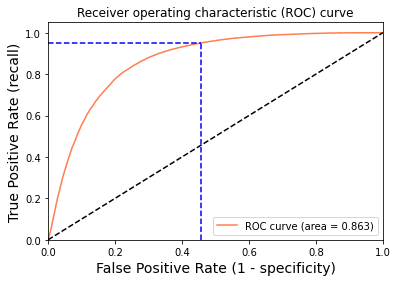

Using a threshold of 0.225 guarantees a recall(from all positive classes, how many we predicted correctly) of 0.950 and a specificity of 0.544, i.e. a false positive rate of 45.59%.


In [90]:
idx = np.min(np.where(tpr > 0.95))
plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a recall(from all positive classes, how many we predicted correctly) of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

#### 3.1.3 Model evaluation based on cross_val_score

In [63]:
logreg = LogisticRegression(max_iter=1000)

scores_accuracy = cross_val_score(logreg, X_log, y_log, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X_log, y_log, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X_log, y_log, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.782
LogisticRegression average log_loss is 0.469
LogisticRegression average auc is 0.862


### 3.2 Random Forest

#### 3.2.1 Feature selection

In [64]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X,y,test_size=0.2,random_state=42)

In [65]:
features_rf = X.columns

In [66]:
rf = RandomForestClassifier()
rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier()

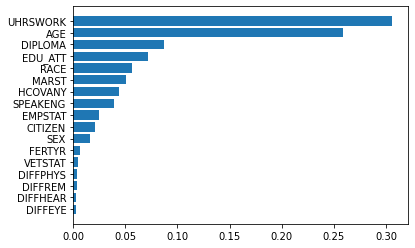

In [54]:
f_i = list(zip(features_rf,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.show()

In [67]:
rfe = RFECV(estimator=rf, step=1, cv=10, scoring='accuracy')
rfe.fit(X_train_rf,y_train_rf)
print('Optimal number of features: {}'.format(rfe.n_features_))
print('Selected features: {}'.format(list(X_train_rf.columns[rfe.support_])))

Optimal number of features: 5
Selected features: ['AGE', 'HCOVANY', 'UHRSWORK', 'EDU_ATT', 'DIPLOMA']


In [68]:
rfe_average_rf = []
for i in rfe.grid_scores_:
    rfe_average_rf.append(i.mean())

C:\Users\83968\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


C:\Users\83968\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


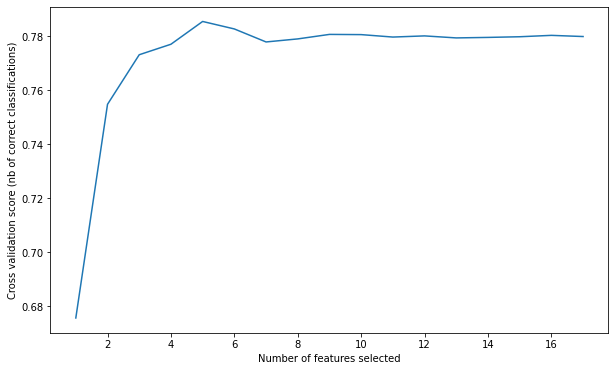

In [69]:
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_)+1), rfe_average_rf)
plt.show()

#### 3.2.2 Model Evaluation 

In [70]:
selected_cols_rf = ['AGE', 'HCOVANY', 'UHRSWORK', 'EDU_ATT', 'DIPLOMA','SEX']
X_rf = df[selected_cols_rf]
y_rf = df['INC_INDEX']
print(X_rf.shape,y_rf.shape)

(514548, 6) (514548,)


In [71]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf,test_size=0.2,random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train_rf, y_train_rf)
y_pred_rf = rf.predict(X_test_rf)
y_pred_proba_rf = rf.predict_proba(X_test_rf)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test_rf, y_pred_proba_rf)
print('Train/Test split results:')
print(rf.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test_rf, y_pred_rf))
print(rf.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test_rf, y_pred_proba_rf))
print(rf.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
RandomForestClassifier accuracy is 0.787
RandomForestClassifier log_loss is 0.605
RandomForestClassifier auc is 0.860


C:\Users\83968\AppData\Local\Temp/ipykernel_142984/3988624874.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
C:\Users\83968\AppData\Local\Temp/ipykernel_142984/3988624874.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')


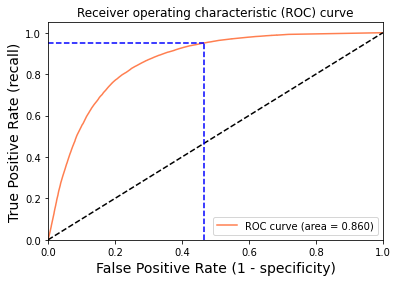

Using a threshold of 0.175 guarantees a recall(from all positive classes, how many we predicted correctly) of 0.950 and a specificity of 0.535, i.e. a false positive rate of 46.50%.


In [72]:
idx = np.min(np.where(tpr > 0.95))
plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a recall(from all positive classes, how many we predicted correctly) of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

Since Logistic Regression model gives similar accuracy to Random Forest Classifier and Logistic Regression has better running time, so we choose to use Logistic Regression

## 4. Fairness

### 4.1 Sex group fairness

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

#### 4.1.1 Fairness Analysis of sex

In [144]:
df_sens = X_test['SEX']
test_sens = df_sens.values

In [149]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.788
Statistical parity: 0.091
Equalized odds: 0.059


#### 4.1.2 Data Augmentation method

Using method from http://krvarshney.github.io/pubs/SharmaZRBMV_aies2020.pdf

In [150]:
X_train_syn = X_train
X_train_syn['SEX'] = X_train_syn['SEX'].replace({0:1,1:0})
y_train_syn = y_train

X_train_aug = pd.concat((X_train, X_train_syn))
y_train_aug = pd.concat((y_train, y_train_syn))

print(X_train_aug.shape, y_train_aug.shape)

(823276, 17) (823276,)


In [152]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_aug, y_train_aug)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.782
Statistical parity: -0.065
Equalized odds: -0.139


### 4.2 Race group fairness

#### 4.2.1 Fairness analysis of Race

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [163]:
df_sens = X_test['RACE']
test_sens = df_sens.values

In [164]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.788
Statistical parity: -0.113
Equalized odds: -0.094


#### 4.2.2 Data Augmentation method

In [165]:
X_train_syn = X_train
X_train_syn['RACE'] = X_train_syn['RACE'].replace({0:1,1:0})
y_train_syn = y_train

X_train_aug = pd.concat((X_train, X_train_syn))
y_train_aug = pd.concat((y_train, y_train_syn))

print(X_train_aug.shape, y_train_aug.shape)

(823276, 17) (823276,)


In [166]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_aug, y_train_aug)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.788
Statistical parity: -0.097
Equalized odds: -0.073


### 4.3 Citizen Group fairness

#### 4.3.1 Fairness analysis of Citizen

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [171]:
df_sens = X_test['CITIZEN']
test_sens = df_sens.values

In [172]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.788
Statistical parity: -0.338
Equalized odds: -0.320


#### 4.3.2 Data Augmentation method

In [173]:
X_train_syn = X_train
X_train_syn['CITIZEN'] = X_train_syn['CITIZEN'].replace({0:1,1:0})
y_train_syn = y_train

X_train_aug = pd.concat((X_train, X_train_syn))
y_train_aug = pd.concat((y_train, y_train_syn))

print(X_train_aug.shape, y_train_aug.shape)

(823276, 17) (823276,)


In [174]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_aug, y_train_aug)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.772
Statistical parity: -0.203
Equalized odds: -0.118


### 4.4 DIFFREM Group Analysis

#### 4.4.1 Fairness analysis of DIFFREM

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [178]:
df_sens = X_test['DIFFREM']
test_sens = df_sens.values

In [179]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.788
Statistical parity: 0.302
Equalized odds: 0.363


#### 4.4.2 Data Augmentation Method

In [180]:
X_train_syn = X_train
X_train_syn['DIFFREM'] = X_train_syn['DIFFREM'].replace({0:1,1:0})
y_train_syn = y_train

X_train_aug = pd.concat((X_train, X_train_syn))
y_train_aug = pd.concat((y_train, y_train_syn))

print(X_train_aug.shape, y_train_aug.shape)

(823276, 17) (823276,)


In [181]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_aug, y_train_aug)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.756
Statistical parity: 0.093
Equalized odds: -0.039


### 4.5 DIFFPHYS Group Analysis

#### 4.5.1 Fairness analysis of DIFFPHYS

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [186]:
df_sens = X_test['DIFFPHYS']
test_sens = df_sens.values

In [187]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.788
Statistical parity: 0.163
Equalized odds: 0.179


#### 4.5.2 Data Augmentation Method

In [199]:
X_train_syn = X_train
X_train_syn['DIFFPHYS'] = X_train_syn['DIFFPHYS'].replace({0:1,1:0})
y_train_syn = y_train

X_train_aug = pd.concat((X_train, X_train_syn))
y_train_aug = pd.concat((y_train, y_train_syn))

print(X_train_aug.shape, y_train_aug.shape)

(823276, 17) (823276,)


In [200]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_aug, y_train_aug)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.772
Statistical parity: 0.004
Equalized odds: -0.073


### 4.6 DIFFEYE Group Analysis

#### 4.6.1 Fairness Analysis of DIFFEYE

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [210]:
df_sens = X_test['DIFFEYE']
test_sens = df_sens.values

In [211]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.788
Statistical parity: 0.168
Equalized odds: 0.175


#### 4.6.2 Data Augmentation Method

In [212]:
X_train_syn = X_train
X_train_syn['DIFFEYE'] = X_train_syn['DIFFEYE'].replace({0:1,1:0})
y_train_syn = y_train

X_train_aug = pd.concat((X_train, X_train_syn))
y_train_aug = pd.concat((y_train, y_train_syn))

print(X_train_aug.shape, y_train_aug.shape)

(823276, 17) (823276,)


In [213]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_aug, y_train_aug)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.779
Statistical parity: 0.065
Equalized odds: 0.012


### 4.7 DIFFHEAR Group Analysis

#### 4.7.1 Fairness Analysis of DIFFHEAR

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [217]:
df_sens = X_test['DIFFHEAR']
test_sens = df_sens.values

In [218]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.788
Statistical parity: 0.026
Equalized odds: 0.013


#### 4.7.2 Data Augmentation Method

In [219]:
X_train_syn = X_train
X_train_syn['DIFFHEAR'] = X_train_syn['DIFFHEAR'].replace({0:1,1:0})
y_train_syn = y_train

X_train_aug = pd.concat((X_train, X_train_syn))
y_train_aug = pd.concat((y_train, y_train_syn))

print(X_train_aug.shape, y_train_aug.shape)

(823276, 17) (823276,)


In [220]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_aug, y_train_aug)
y_pred = clf.predict(X_test)
stat_p = stat_parity(y_pred, test_sens)
eq_op = eq_oppo(y_pred, test_sens, y_test.values)
print('Accuracy socre: %2.3f' % accuracy_score(y_test,y_pred))
print('Statistical parity: %2.3f' % stat_p)
print('Equalized odds: %2.3f' % eq_op)

Accuracy socre: 0.784
Statistical parity: -0.033
Equalized odds: -0.063
